In [2]:
import pandas as pd
from keras.preprocessing import sequence
from keras.models import *
from keras.layers import *
from keras.utils import np_utils
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1050 Ti (0000:01:00.0)


# Import Data

In [41]:
data = pd.read_csv('train_parsed_reduced.csv', header=None)
data = data.sample(frac=1)

In [42]:
def read_data(dataset):
    data = pd.read_csv(dataset, header=None)
    #data.drop(data.columns[[0]], axis=1, inplace=True)
    data = data.sample(frac=1)
    data = data.values
    n = data.shape[1] - 1
    x = data[:,0:n]
    y = data[:,n]
    y_categorical = np_utils.to_categorical(y)
    return (x, y, y_categorical)

In [43]:
x_train, y_train, y_categorical_train = read_data('train_parsed_reduced.csv')
print(x_train.shape)
x_test, y_test, y_categorical_test = read_data('test_parsed.csv')

(1035L, 1323L)


In [59]:
#x_train, x_test, y_train,  y_test = train_test_split(x, y)
#x_train, x_test, y_categorical_train, y_categorical_test = train_test_split(x, y_categorical)

In [6]:
print(x_train[0])
print(y_categorical_train[0])

[ 13.  18.   7. ...,   0.   0.   0.]
[ 0.  1.]


In [7]:
n = x_train.shape[1]

In [8]:
len(set(values.flatten()))

NameError: name 'values' is not defined

# CovNet

In [8]:
maxlen = n
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#print(x_train.shape)

In [9]:

model = Sequential()
def DenseBlock(num):
    def f(model):
        model = Dropout(0.5)(model)
        model = Dense(num)(model)
        model = BatchNormalization()(model)
        model = Activation('relu')(model)
        return model
    return f
def InputBlock(num, shape):
    def f(model):
        model = Dense(num, input_shape=shape)(model)
        return model
    return f
def OutputBlock(shape):
    def f(model):
        model = Dense(shape)(model)
        model = Activation('softmax')(model)
        return model
    return f
def ConvBlock(kernel_size, filters):
    def f(model):
        x = Convolution2D(filters, 1, kernel_size, border_mode='same', activation='relu')(model)
        model = MaxPooling2D((1, kernel_size))(model)
        model = Flatten()(model)
        return model
    return f

window_size = 31
Y = 150
maxlen = 800

inp = Input(shape=(maxlen,))
model = Embedding(n, Y)(inp)
model = Reshape((1, maxlen, Y))(model)
#ca = ConvBlock(3, 10)(model)
#cb = ConvBlock(5, 10)(model)
#model = merge([ca, cb], mode='concat')
model = ConvBlock(1, n)(model) 
model = DenseBlock(16)(model)
model = DenseBlock(16)(model)
model = OutputBlock(2)(model)
model = Model(inp, model)

In [9]:
#Model 2
model = Sequential()
def DenseBlock(num):
    def f(model):
        model = Dropout(0.5)(model)
        model = Dense(num)(model)
        model = BatchNormalization()(model)
        model = Activation('relu')(model)
        return model
    return f
def InputBlock(num, shape):
    def f(model):
        model = Dense(num, input_shape=shape)(model)
        return model
    return f
def OutputBlock(shape):
    def f(model):
        model = Dense(shape)(model)
        model = Activation('softmax')(model)
        return model
    return f
def ConvBlock(kernel_size, filters):
    def f(model):
        x = Convolution2D(filters, 1, kernel_size, border_mode='same', activation='relu')(model)
        model = MaxPooling2D((1, kernel_size))(model)
        model = Flatten()(model)
        return model
    return f

inp = Input(shape=(maxlen,))
model = Embedding(n, 16)(inp)
model = Flatten()(model)
model = DenseBlock(16)(model)
model = DenseBlock(16)(model)
model = OutputBlock(2)(model)
model = Model(inp, model)

In [12]:
# Model 3
max_features = n
maxlen = 100
vocab = 30
length = n
embedding_vector = 8

model = Sequential()
model.add(Embedding(vocab, embedding_vector, input_length=length)) # embed into dense 3D float tensor (samples, maxlen, 256)
model.add(Reshape((1, length, embedding_vector))) # reshape into 4D tensor (samples, 1, maxlen, 256)
# VGG-like convolution stack
model.add(Convolution2D(128, 3, 3, border_mode='full')) 
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(64, 2, 2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(2))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 1323L, 8)      240         embedding_input_1[0][0]          
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 1, 1323L, 8)   0           embedding_2[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 3, 1325L, 128) 9344        reshape_2[0][0]                  
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 3, 1325L, 128) 0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [33]:
vocab = 50
length = n
embedding_vector = 8
n_timesteps = 20

model = Sequential()
model.add(Embedding(input_dim=vocab, output_dim=embedding_vector, input_length=length))
model.add(Reshape((1, length, embedding_vector)))
model.add(Convolution2D(128, 1, 31, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 31)))
model.add(Flatten())
#model.add(Reshape((5376, 1)))
#model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps,)))
#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#model.add(GlobalMaxPool1D())
#model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_6 (Embedding)          (None, 1323L, 8)      400         embedding_input_5[0][0]          
____________________________________________________________________________________________________
reshape_6 (Reshape)              (None, 1, 1323L, 8)   0           embedding_6[0][0]                
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 1, 1323L, 128) 31872       reshape_6[0][0]                  
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 1, 1323L, 128) 0           convolution2d_7[0][0]            
___________________________________________________________________________________________

In [34]:
op = Adam(lr=0.00001)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
def learn(lr, epochs):
    op.lr = lr
    model.fit(x=x_train, y=y_categorical_train, nb_epoch=epochs, batch_size=64, validation_data=(x_test, y_categorical_test), verbose=1)

In [70]:
learn(0.0015, 15)

Train on 1035 samples, validate on 186 samples
Epoch 1/15
1035/1035 [==============================] - 0s - loss: 0.0457 - acc: 0.9845 - val_loss: 1.0050 - val_acc: 0.7312
Epoch 2/15
1035/1035 [==============================] - 0s - loss: 0.0449 - acc: 0.9874 - val_loss: 0.9607 - val_acc: 0.7419
Epoch 3/15
1035/1035 [==============================] - 0s - loss: 0.1068 - acc: 0.9652 - val_loss: 0.9297 - val_acc: 0.7366
Epoch 4/15
1035/1035 [==============================] - 0s - loss: 0.0374 - acc: 0.9903 - val_loss: 1.0854 - val_acc: 0.6989
Epoch 5/15
1035/1035 [==============================] - 0s - loss: 0.0330 - acc: 0.9913 - val_loss: 1.1505 - val_acc: 0.7473
Epoch 6/15
1035/1035 [==============================] - 0s - loss: 0.0177 - acc: 0.9971 - val_loss: 1.1870 - val_acc: 0.7419
Epoch 7/15
1035/1035 [==============================] - 0s - loss: 0.0166 - acc: 0.9961 - val_loss: 1.2886 - val_acc: 0.7366
Epoch 8/15
1035/1035 [==============================] - 0s - loss: 0.0250 - ac

In [54]:
model.evaluate(x=x_train, y=y_categorical_train, batch_size=1)

186/186 [==============================] - ETA: 0s E - 0s     


[0.59394702585537962, 0.70967741935483875]

In [194]:
y_pred = np.argmax(model.predict(x=x_train, batch_size=1), axis=1)
y_true = y_categorical_train[:, -1] 

In [195]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[545,   3],
       [  2, 485]], dtype=int64)

In [66]:
# Convolution layers expect a 4-D input so we reshape our 2-D input
nb_samples = x_train.shape[0]
nb_features = x_train.shape[1]
newshape = (nb_samples, 1, nb_features, 1)
x_train = np.reshape(x_train, newshape).astype(theano.config.floatX)

# We set some hyperparameters
BATCH_SIZE = 16
FIELD_SIZE = 5 * 300
STRIDE = 300
N_FILTERS = 200

# We fit the model
model = Sequential()
model.add(Convolution2D(nb_filter=N_FILTERS, stack_size=1, nb_row=FIELD_SIZE, 
                        nb_col=1, subsample=(STRIDE, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(poolsize=(((nb_features - FIELD_SIZE) / STRIDE) + 1, 1)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(N_FILTERS, nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')
print 'fitting model'
model.fit(x_train, y_categorical_train, nb_epoch=10, batch_size=BATCH_SIZE, verbose=1, 
          show_accuracy=True, validation_split=0.1)

NameError: name 'theano' is not defined

# Good Models

In [10]:
#Model 4
vocab = 30
length = n
embedding_vector = 12
n_timesteps = 20

model = Sequential()
model.add(Embedding(input_dim=vocab, output_dim=embedding_vector, input_length=length))
model.add(Reshape((1, length, embedding_vector)))
model.add(Convolution2D(254, 1, 5, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 5)))
model.add(Flatten())
#model.add(Reshape((5376, 1)))
#model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps,)))
#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#model.add(GlobalMaxPool1D())
#model.add(Flatten())
#model.add(Dropout(0.7))
model.add(Dense(16))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(8))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.7))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

op = Adam(lr=0.00001)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

def learn(lr, epochs):
    op.lr = lr
    model.fit(x=x_train, y=y_categorical_train, nb_epoch=epochs, batch_size=64, validation_data=(x_test, y_categorical_test), verbose=1)

#Train
learn(0.0015, 5)
learn(0.00015, 5)
learn(0.000015, 5)
#Accuracy Reduced: Train 94, Test 78
#Accuracy: Train 96, Test 85

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 1323L, 12)     360         embedding_input_1[0][0]          
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 1, 1323L, 12)  0           embedding_1[0][0]                
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 1, 1323L, 254) 15494       reshape_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1, 1323L, 254) 0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [12]:
learn(0.0015, 15)

Train on 1035 samples, validate on 186 samples
Epoch 1/15
1035/1035 [==============================] - 1s - loss: 0.5707 - acc: 0.6705 - val_loss: 0.6195 - val_acc: 0.6774
Epoch 2/15
1035/1035 [==============================] - 1s - loss: 0.5747 - acc: 0.6947 - val_loss: 0.6116 - val_acc: 0.6989
Epoch 3/15
1035/1035 [==============================] - 1s - loss: 0.5906 - acc: 0.6821 - val_loss: 0.6074 - val_acc: 0.6559
Epoch 4/15
1035/1035 [==============================] - 1s - loss: 0.5420 - acc: 0.7043 - val_loss: 0.5991 - val_acc: 0.69350.7 - ETA: 0s - loss: 0.5404 - ac
Epoch 5/15
1035/1035 [==============================] - 1s - loss: 0.5342 - acc: 0.7333 - val_loss: 0.6071 - val_acc: 0.6882TA: 0s - loss: 0.5312 - acc: 0.7
Epoch 6/15
1035/1035 [==============================] - 1s - loss: 0.5502 - acc: 0.6995 - val_loss: 0.6591 - val_acc: 0.6882- ETA: 0s - loss: 0.5457 - acc: 0.71 - ETA: 0s - loss: 0.5436 - acc: 
Epoch 7/15
1035/1035 [==============================] - 1s - loss: 0.

# Graph

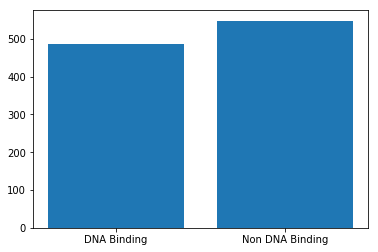

In [130]:
import matplotlib.pyplot as plt
objects=('DNA Binding','Non DNA Binding')
y_pos=[1,2]
plt.bar([1,2],[487,548],align='center')
plt.xticks(y_pos,objects)
plt.show()

In [128]:
col = lambda x: data.iloc[:, x]
len(col(-1)) - col(-1).sum()

548.0

In [150]:
def generate_roc(n_classes, y_test, y_score):
	# Compute ROC curve and ROC area for each class
	from sklearn.metrics import roc_curve, auc
	fpr = dict()
	tpr = dict()
	roc_auc = dict()
	for i in range(n_classes):
	    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
	    roc_auc[i] = auc(fpr[i], tpr[i])

	# Compute micro-average ROC curve and ROC area
	fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
	roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
	return fpr, tpr, roc_auc

In [167]:
def generate_graph(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

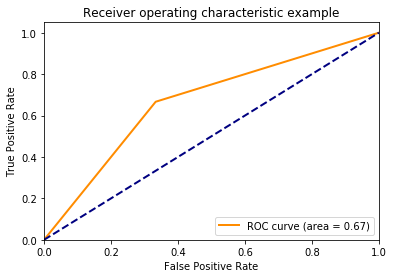

In [174]:
y_test = np.array([
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 1],
])
y_score = np.array([
    [1, 1],
    [0, 1],
    [1, 1],
    [0, 1],
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 0],
    [1, 1],
    [0, 0],
    [1, 0],
    [0, 0],
])

fpr, tpr, roc_auc = generate_roc(2, y_test, y_score)
generate_graph(fpr, tpr, roc_auc)

In [176]:
x_test.shape

(186L, 1323L)

## Confusion Matrix

In [199]:
def generate_confusion_matrix(X, y):
    from sklearn.metrics import confusion_matrix
    y_pred = np.argmax(model.predict(x=X, batch_size=1), axis=1)
    y_true = y[:, -1]
    return confusion_matrix(y_true, y_pred)

In [200]:
generate_confusion_matrix(x_train, y_categorical_train)

array([[545,   3],
       [  2, 485]], dtype=int64)

# Model Architecture

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: cannot import name plot_model

# Final Model

In [ ]:
vocab = 50
length = n
embedding_vector = 8
n_timesteps = 20

model = Sequential()
model.add(Embedding(input_dim=vocab, output_dim=embedding_vector, input_length=length))
model.add(Reshape((1, length, embedding_vector)))
model.add(Convolution2D(128, 1, 31, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 31)))
model.add(Flatten())
#model.add(Reshape((5376, 1)))
#model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps,)))
#model.add(TimeDistributed(Dense(1, activation='sigmoid')))
#model.add(GlobalMaxPool1D())
#model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

op = Adam(lr=0.00001)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=['accuracy'])

def learn(lr, epochs):
    op.lr = lr
    model.fit(x=x_train, y=y_categorical_train, nb_epoch=epochs, batch_size=64, validation_data=(x_test, y_categorical_test), verbose=1)

learn(0.0015, 20)
#AUC: 0.74193548387096775


In [58]:
def fix_col(data):
    return data.reshape( ( data.shape[0], 1 ) )

In [63]:
from sklearn.metrics import roc_curve
y_pred_keras = np.argmax(model.predict(x_test), axis=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(fix_col(y_test), fix_col(y_pred_keras))

In [64]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [49]:
y_test = y_test.reshape((y_test.shape[0], 1))

In [65]:
auc_keras

0.74193548387096775

In [53]:
x_test.shape

(186L, 1323L)

In [62]:
np.argmax(y_pred_keras, axis=1)

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0], dtype=int64)